In [7]:
import re
import random
import json
from pathlib import Path
from collections import Counter
import thinc.extra.datasets
import spacy
import torch
from spacy.util import minibatch
import tqdm
import unicodedata
import wasabi
from spacy_pytorch_transformers.util import cyclic_triangular_rate

In [38]:
https://github.com/explosion/spacy-pytorch-transformers/blob/master/examples/train_textcat.py
def main(
    model,
    input_dir=None,
    output_dir=None,
    n_iter=1,
    n_texts=100,
    batch_size=8,
    learn_rate=2e-5,
    max_wpb=1000,
    use_test=False,
    pos_label=None,
):
    spacy.util.fix_random_seed(0)
    is_using_gpu = spacy.prefer_gpu()
    if is_using_gpu:
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()

    nlp = spacy.load(model)
    print(nlp.pipe_names)
    print(f"Loaded model '{model}'")
    textcat = nlp.create_pipe(
        "pytt_textcat", config={"architecture": "softmax_last_hidden", "words_per_batch": max_wpb}
    )
    if input_dir is not None:
        train_texts, train_cats = read_inputs(input_dir / "training.jsonl")
        eval_texts, eval_cats = read_inputs(input_dir / "evaluation.jsonl")
        labels = set()
        for cats in train_cats + eval_cats:
            labels.update(cats)
        # use the first label in the set as the positive label if one isn't
        # provided
        for label in sorted(labels):
            if not pos_label:
                pos_label = label
            textcat.add_label(label)
    else:
        # add label to text classifier
        textcat.add_label("POSITIVE")
        textcat.add_label("NEGATIVE")
        if not pos_label:
            pos_label = "POSITIVE"
        # load the IMDB dataset
        print("Loading IMDB data...")
        if use_test:
            (train_texts, train_cats), (
                eval_texts,
                eval_cats,
            ) = load_data_for_final_test(limit=n_texts)
        else:
            (train_texts, train_cats), (eval_texts, eval_cats) = load_data(
                limit=n_texts
            )

    print("Labels:", textcat.labels)
    print("Positive label for evaluation:", pos_label)
    nlp.add_pipe(textcat, last=True)
    print(f"Using {len(train_texts)} training docs, {len(eval_texts)} evaluation")
    split_training_by_sentence = False
    if split_training_by_sentence:
        # If we're using a model that averages over sentence predictions (we are),
        # there are some advantages to just labelling each sentence as an example.
        # It means we can mix the sentences into different batches, so we can make
        # more frequent updates. It also changes the loss somewhat, in a way that's
        # not obviously better -- but it does seem to work well.
        train_texts, train_cats = make_sentence_examples(nlp, train_texts, train_cats)
        print(f"Extracted {len(train_texts)} training sents")
    # total_words = sum(len(text.split()) for text in train_texts)
    train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))
    # Initialize the TextCategorizer, and create an optimizer.
    optimizer = nlp.resume_training()
    optimizer.alpha = 0.001
    optimizer.pytt_weight_decay = 0.005
    optimizer.L2 = 0.0
    learn_rates = cyclic_triangular_rate(
        learn_rate / 3, learn_rate * 3, 2 * len(train_data) // batch_size
    )
    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))

    pbar = tqdm.tqdm(total=20, leave=False)
    results = []
    epoch = 0
    step = 0
    eval_every = 20
    patience = 3
    for _ in range(n_iter):
        # Train and evaluate
        losses = Counter()
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_size)
        for batch in batches:
            optimizer.pytt_lr = next(learn_rates)
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.1, losses=losses)
            pbar.update(1)
            if step and (step % eval_every) == 0:
                pbar.close()
                with nlp.use_params(optimizer.averages):
                    scores = evaluate(nlp, eval_texts, eval_cats, pos_label)
                results.append((scores["textcat_f"], step, epoch))
                print(
                    "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(
                        losses["pytt_textcat"],
                        scores["textcat_p"],
                        scores["textcat_r"],
                        scores["textcat_f"],
                    )
                )
                pbar = tqdm.tqdm(total=eval_every, leave=False)
            step += 1
        epoch += 1
        # Stop if no improvement in HP.patience checkpoints
        if results:
            best_score, best_step, best_epoch = max(results)
            if ((step - best_step) // eval_every) >= patience:
                break

    msg = wasabi.Printer()
    table_widths = [2, 4, 6]
    msg.info(f"Best scoring checkpoints")
    msg.row(["Epoch", "Step", "Score"], widths=table_widths)
    msg.row(["-" * width for width in table_widths])
    for score, step, epoch in sorted(results, reverse=True)[:10]:
        msg.row([epoch, step, "%.2f" % (score * 100)], widths=table_widths)

    # Test the trained model
    test_text = eval_texts[0]
    doc = nlp(test_text)
    print(test_text, doc.cats)

    if output_dir is not None:
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)
        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        print(test_text, doc2.cats)


def read_inputs(input_path):
    texts = []
    cats = []
    with input_path.open(mode="r") as file_:
        for line in file_:
            text, gold = json.loads(line)
            text = preprocess_text(text)
            texts.append(text)
            cats.append(gold["cats"])
    return texts, cats


def make_sentence_examples(nlp, texts, labels):
    """Treat each sentence of the document as an instance, using the doc labels."""
    sents = []
    sent_cats = []
    for text, cats in zip(texts, labels):
        doc = nlp.make_doc(text)
        doc = nlp.get_pipe("sentencizer")(doc)
        for sent in doc.sents:
            sents.append(sent.text)
            sent_cats.append(cats)
    return sents, sent_cats


white_re = re.compile(r"\s\s+")


def preprocess_text(text):
    text = text.replace("<s>", "<open-s-tag>")
    text = text.replace("</s>", "<close-s-tag>")
    text = white_re.sub(" ", text).strip()
    return "".join(
        c for c in unicodedata.normalize("NFD", text) if unicodedata.category(c) != "Mn"
    )


def load_data(*, limit=0, dev_size=2000):
    """Load data from the IMDB dataset, splitting off a held-out set."""
    if limit != 0:
        limit += dev_size
    assert dev_size != 0
    train_data, _ = thinc.extra.datasets.imdb(limit=limit)
    assert len(train_data) > dev_size
    random.shuffle(train_data)
    dev_data = train_data[:dev_size]
    train_data = train_data[dev_size:]
    train_texts, train_labels = _prepare_partition(train_data, preprocess=False)
    dev_texts, dev_labels = _prepare_partition(dev_data, preprocess=False)
    return (train_texts, train_labels), (dev_texts, dev_labels)


def load_data_for_final_test(*, limit=0):
    print(
        "Warning: Using test data. You should use development data for most experiments."
    )
    train_data, test_data = thinc.extra.datasets.imdb()
    random.shuffle(train_data)
    train_data = train_data[-limit:]
    train_texts, train_labels = _prepare_partition(train_data)
    test_texts, test_labels = _prepare_partition(test_data)
    return (train_texts, train_labels), (test_texts, test_labels)


def _prepare_partition(text_label_tuples, *, preprocess=False):
    texts, labels = zip(*text_label_tuples)
    if preprocess:
        # Preprocessing can mask errors in our handling of noisy text, so
        # we don't want to do it by default
        texts = [preprocess_text(text) for text in texts]
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    return texts, cats


def evaluate(nlp, texts, cats, pos_label):
    tp = 0.0  # True positives
    fp = 0.0  # False positives
    fn = 0.0  # False negatives
    tn = 0.0  # True negatives
    total_words = sum(len(text.split()) for text in texts)
    with tqdm.tqdm(total=total_words, leave=False) as pbar:
        for i, doc in enumerate(nlp.pipe(texts, batch_size=8)):
            gold = cats[i]
            for label, score in doc.cats.items():
                if label not in gold:
                    continue
                if label != pos_label:
                    continue
                if score >= 0.5 and gold[label] >= 0.5:
                    tp += 1.0
                elif score >= 0.5 and gold[label] < 0.5:
                    fp += 1.0
                elif score < 0.5 and gold[label] < 0.5:
                    tn += 1
                elif score < 0.5 and gold[label] >= 0.5:
                    fn += 1
            pbar.update(len(doc.text.split()))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}

main("en_pytt_distilbertbaseuncased_lg", output_dir="output")

['sentencizer', 'pytt_wordpiecer', 'pytt_tok2vec']
Loaded model 'en_pytt_distilbertbaseuncased_lg'
Loading IMDB data...




  0%|          | 0/20 [00:00<?, ?it/s]

Labels: ('POSITIVE', 'NEGATIVE')
Positive label for evaluation: POSITIVE
Using 100 training docs, 2000 evaluation
Training the model...
LOSS 	  P  	  R  	  F  




  5%|▌         | 1/20 [00:07<02:28,  7.79s/it]

 10%|█         | 2/20 [00:24<03:09, 10.52s/it]

 15%|█▌        | 3/20 [00:38<03:13, 11.40s/it]

 20%|██        | 4/20 [00:49<03:04, 11.51s/it]

 25%|██▌       | 5/20 [00:59<02:42, 10.81s/it]

 30%|███       | 6/20 [01:14<02:50, 12.16s/it]

 35%|███▌      | 7/20 [01:31<02:58, 13.74s/it]

 40%|████      | 8/20 [01:41<02:30, 12.54s/it]

 45%|████▌     | 9/20 [01:52<02:13, 12.18s/it]

 50%|█████     | 10/20 [02:05<02:03, 12.32s/it]

 55%|█████▌    | 11/20 [02:24<02:08, 14.27s/it]

 60%|██████    | 12/20 [02:37<01:50, 13.84s/it]

 65%|██████▌   | 13/20 [02:45<01:25, 12.22s/it]

ℹ Best scoring checkpoints
Epoch   Step   Score 
--   ----   ------
This movie was so poorly written and directed I fell asleep 30 minutes through the movie. The jokes in the movie are corny and even though the plot is interesting at some angles, it is too far fetched and at some points- ridiculous. If you are 11 or older you will overlook the writing in the movie and be disappointed, but if you are 10 or younger this is a film that will capture your attention and be amazed with all the stunts (which I might add are poorly done) and wish you were some warrior to. The casting in this movie wasn't very good, and the music was very disappointing because it was like they were trying to build up the tension but it didn't fit at all. On a scale of 1-10 (10 being excellent, 1 being horrible) the acting in this movie is a 4. Brenda Song is talented in comedy, but with this kind of movie, in some of the more serious scenes, her acting was laughable. When she made some of her "fighting" poses, I

In [39]:
nlp = spacy.load("output")

In [34]:
import bodleian_downloader
from lxml import etree
import standoffconverter
texts = []
speakers = []

for fn in bodleian_downloader.get_file_descriptors():

    tree = etree.fromstring(open(fn, "rb").read())
    break


In [35]:
for speech in tree.findall(".//{http://www.tei-c.org/ns/1.0}sp"):
    speaker = speech.findall(".//{http://www.tei-c.org/ns/1.0}speaker")
    
    lines = speech.findall(".//{http://www.tei-c.org/ns/1.0}l")
    if len(speaker) > 0:
        for line in lines:
            so = standoffconverter.Standoff()
            so.from_lxml_tree(line)
            
            texts.append(so.plain)
            speakers.append(speaker[0].text)
        

In [59]:
scores = []
for i, doc in enumerate(nlp.pipe(texts, batch_size=8)):
    for label, score in doc.cats.items():
        if label == "POSITIVE":
            scores.append(score)

In [60]:
label

'NEGATIVE'

In [61]:
label

'NEGATIVE'

In [62]:
import numpy as np
scores = np.array(scores)
speakers = np.array(speakers)

uspeakers = np.array(sorted(list(set(speakers))))
mean_scores = np.empty(len(uspeakers))
for ispeaker,uspeaker in enumerate(uspeakers):
    mean_scores[ispeaker] = scores[speakers == uspeaker].mean()

In [69]:
from collections import Counter

cnt = Counter(speakers)

labels,_ = zip(*cnt.most_common(10))

<BarContainer object of 10 artists>

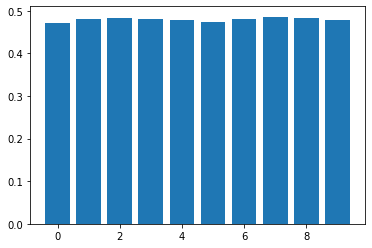

In [77]:
import matplotlib.pyplot as plt

plt.bar(range(len(labels)), mean_scores[[uspeakers[i] in labels for i in range(len(uspeakers))]])
plt.xlabels()

In [75]:
uspeakers


array(['Ar.', 'Art.', 'Arth.', 'Arthur.', 'Aus.', 'Aust.', 'Ba.', 'Bast.',
       'Big.', 'Bla.', 'Blan.', 'Blanch.', 'Chat.', 'Cit.', 'Con.',
       'Cons.', 'Const.', 'Daul.', 'Dol.', 'Dolph.', 'E. Har.', 'Ele.',
       'Elea.', 'Elen.', 'Eli.', 'Elinor.', 'Eng.', 'Essex.', 'Exec.',
       'F. Her.', 'Fra.', 'Fran.', 'France.', 'Gour.', 'H', 'Hen.', 'Hu.',
       'Hub.', 'Hubert.', 'Io.', 'Ioh.', 'Iohn.', 'K. Io.', 'K. Iohn.',
       'Kin.', 'King Iohn.', 'King.', 'Lady.', 'Lew.', 'Lewis.', 'Mel.',
       'Mes.', 'Old Qu.', 'P.', 'Pan.', 'Pand.', 'Pem.', 'Pem. Big.',
       'Pet.', 'Phi.', 'Phil.', 'Philip.', 'Qu.', 'Qu. Mo.', 'Que.',
       'Queen.', 'Rob.', 'Robert.', 'Sal.'], dtype='<U10')